In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import auc, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split

from util_functions import preprocess_features, preprocess_features_encode, preprocess_targets

### Load data
Please make sure to run the ../data/download_dataset.py file prior to loading the data for the first time

In [2]:
data = pd.read_parquet("../data/01_raw/diabetes_1999_2008_original.parquet")

In [3]:
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

None

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [4]:
x_processed = preprocess_features(data)
display(x_processed.info())

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101763 non-null  object
 1   gender                    101763 non-null  object
 2   age                       101763 non-null  int64 
 3   admission_type_id         101763 non-null  object
 4   discharge_disposition_id  101763 non-null  object
 5   time_in_hospital          101763 non-null  int64 
 6   medical_specialty         101763 non-null  object
 7   num_lab_procedures        101763 non-null  int64 
 8   num_procedures            101763 non-null  int64 
 9   num_medications           101763 non-null  int64 
 10  number_outpatient         101763 non-null  int64 
 11  number_emergency          101763 non-null  int64 
 12  number_inpatient          101763 non-null  int64 
 13  diag_1                    101763 non-null  object
 14  diag_2   

None

In [5]:
cat_data = x_processed.select_dtypes(["object"])
num_data = x_processed.select_dtypes(["number"])
print(num_data.columns)
print(cat_data.columns)

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')
Index(['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')


In [6]:
y_processed = preprocess_targets(x_processed)

x_processed_inp = x_processed.drop(["readmitted"], axis=1)
X_enc = preprocess_features_encode(x_processed_inp)
X_enc = pd.get_dummies(x_processed_inp, drop_first=True, dtype=int)

X_enc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 71 columns):
 #   Column                                           Non-Null Count   Dtype
---  ------                                           --------------   -----
 0   age                                              101763 non-null  int64
 1   time_in_hospital                                 101763 non-null  int64
 2   num_lab_procedures                               101763 non-null  int64
 3   num_procedures                                   101763 non-null  int64
 4   num_medications                                  101763 non-null  int64
 5   number_outpatient                                101763 non-null  int64
 6   number_emergency                                 101763 non-null  int64
 7   number_inpatient                                 101763 non-null  int64
 8   number_diagnoses                                 101763 non-null  int64
 9   A1Cresult                                 

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y_processed, stratify=y_processed, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

param_grid_xgb = {
    "n_estimators": [50, 100],
    "learning_rate": [0.1, 0.3],
    "max_depth": [3, 5],
    "alpha": [0.1, 0.5],
}

clf = GridSearchCV(
    xgb.XGBClassifier(
        tree_method="hist",
        # use_label_encoder=False,
        scale_pos_weight=6,
    ),
    param_grid_xgb,
    n_jobs=-1,
    scoring="f1_micro",
)


clf.fit(X_train, y_train)

best_params_xgb = clf.best_params_
xgb_model = clf.best_estimator_

# Save model into JSON format.
xgb_model.save_model("../model/model.bst")

b = xgb.Booster(model_file="../model/model.bst")

y_pred_xgb = xgb_model.predict(X_test)
predicted_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

y_pred_random = np.random.choice([1, 0], size=y_test.shape, p=[1.0 / 10, 9.0 / 10])

print(classification_report(y_test, y_pred_xgb, target_names=["Not readmitted", "Readmitted"]))
print(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

print(classification_report(y_test, y_pred_random, target_names=["Not readmitted", "Readmitted"]))
print(roc_auc_score(y_test, y_pred_random))

                precision    recall  f1-score   support

Not readmitted       0.91      0.84      0.87     27122
    Readmitted       0.22      0.36      0.27      3407

      accuracy                           0.79     30529
     macro avg       0.57      0.60      0.57     30529
  weighted avg       0.83      0.79      0.81     30529

0.6696045850677608
                precision    recall  f1-score   support

Not readmitted       0.89      0.90      0.89     27122
    Readmitted       0.11      0.09      0.10      3407

      accuracy                           0.81     30529
     macro avg       0.50      0.50      0.50     30529
  weighted avg       0.80      0.81      0.81     30529

0.49722391688193546


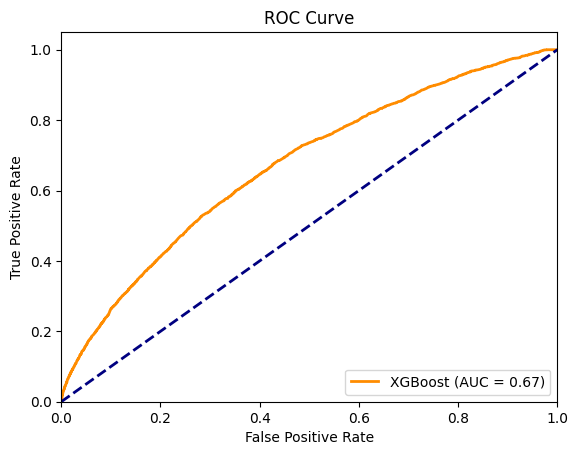

In [8]:

y_scores = predicted_prob_xgb

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="XGBoost (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

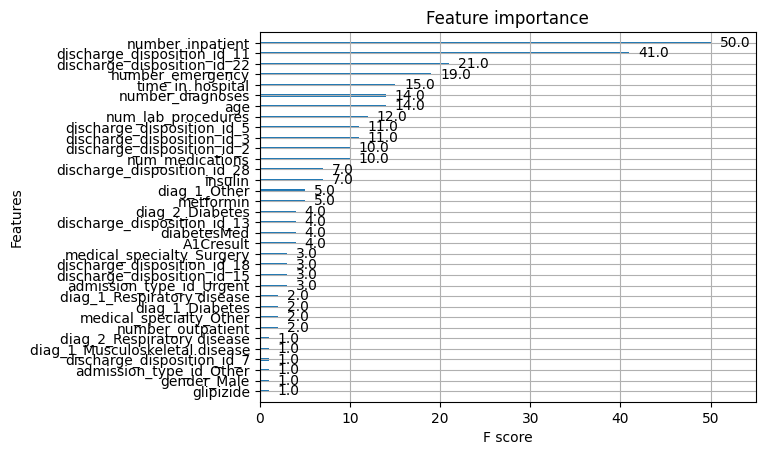

In [9]:
xgb.plot_importance(xgb_model)

In [10]:
X_test.head(5).values

array([[45,  1, 35,  0,  7,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,
         0,  1,  0,  0,  0,  0,  0],
       [55,  2, 73,  0, 14,  0,  0,  1,  9,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,
         0,  0,  0,  1,  0,  0,  0],
       [65,  4, 54,  2, 26,  3,  0,  0,  8,  2,  1,  0,  0,  0,  1,  0,
         0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,
         0,  1,  0,  0,  0,  0,  0],
       [45, 12, 34,  2, 1